In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [2]:
import tensorflow as tf

# Step 1: Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Check dataset shapes
print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training set: (50000, 32, 32, 3) (50000, 1)
Test set: (10000, 32, 32, 3) (10000, 1)


## Step 1: Load CIFAR-10 Dataset

We use the CIFAR-10 dataset, which contains 60,000 32×32 color images across 10 classes. The training set has 50,000 images, and the test set has 10,000.

This step loads the data into memory in its original resolution for use in the preprocessing pipeline.

In [3]:
# x_train = tf.image.resize(x_train, (224, 224))  # Resize to match model input
# x_test = tf.image.resize(x_test, (224, 224))
# x_train = preprocess_input(x_train)
# x_test = preprocess_input(x_test)


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
num_classes = 10

In [5]:
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    label = tf.one_hot(label[0], num_classes)
    return image, label

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .shuffle(10000) \
    .map(preprocess, num_parallel_calls=AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(AUTOTUNE)

In [7]:
# Rebuild the test dataset pipeline
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess, num_parallel_calls=AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(AUTOTUNE)

## Step 2: Efficient Preprocessing with `tf.data`

Instead of resizing all images at once (which would exhaust RAM), we create a TensorFlow dataset pipeline that:
- Loads data on the fly
- Resizes images to 224×224 (required by MobileNetV2)
- Normalizes images using `preprocess_input`
- One-hot encodes the labels
- Batches and prefetches data efficiently for training

In [8]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,           # Don't include the default classification layer
    weights='imagenet'           # Load pretrained weights
)
base_model.trainable = False     # Freeze the convolutional base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 3: Load Pretrained MobileNetV2

We use MobileNetV2 as a feature extractor. By setting `include_top=False`, we remove the original classification layers. We also freeze its weights so training focuses only on the new classification head we add later.

In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),    # Reduces feature maps to a vector
    layers.Dropout(0.2),                # Helps prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
])

## Step 3.2: Add Custom Classification Layers

A new head is built on top of MobileNetV2. It includes:
- Global Average Pooling to reduce features
- Dropout to reduce overfitting
- Dense layers for classification
- A final softmax layer for 10 CIFAR-10 classes

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Step 3.3: Compile the Model

We compile the model using:
- `Adam` optimizer for adaptive learning
- `categorical_crossentropy` loss for multi-class classification
- `accuracy` as our evaluation metric

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.5,
    verbose=1
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.7497 - loss: 0.7460 - val_accuracy: 0.8320 - val_loss: 0.4873 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 33ms/step - accuracy: 0.8315 - loss: 0.4863 - val_accuracy: 0.8426 - val_loss: 0.4513 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8454 - loss: 0.4386 - val_accuracy: 0.8381 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8561 - loss: 0.4099 - val_accuracy: 0.8482 - val_loss: 0.4454 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8635 - loss: 0.3846 - val_accuracy: 0.8574 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.8732 - loss: 0.3602 - val_accuracy: 0.8532 - val_loss: 0.4323 - learning_rate: 0.0010
Epoch 7/20
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accurac

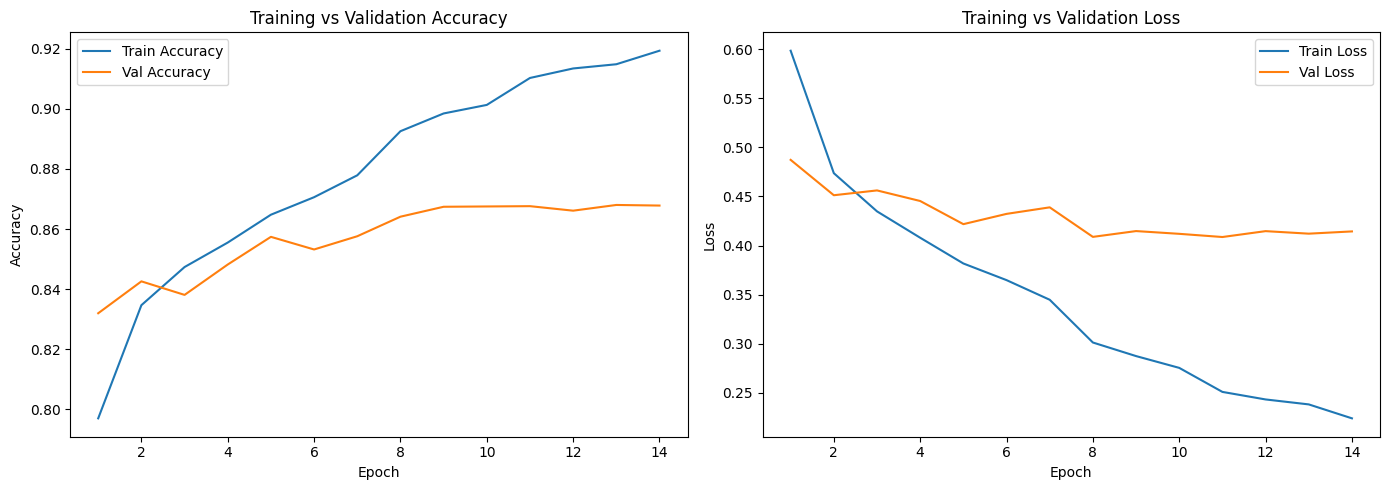

In [13]:
import matplotlib.pyplot as plt

# Retrieve values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

In [16]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.7,
    min_lr=1e-6,
    verbose=1
)

In [19]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.7536 - loss: 0.7247 - val_accuracy: 0.8353 - val_loss: 0.4713 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 34ms/step - accuracy: 0.8315 - loss: 0.4866 - val_accuracy: 0.8414 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.8460 - loss: 0.4410 - val_accuracy: 0.8480 - val_loss: 0.4390 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.8555 - loss: 0.4030 - val_accuracy: 0.8539 - val_loss: 0.4280 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.8610 - loss: 0.3894 - val_accuracy: 0.8501 - val_loss: 0.4331 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.8707 - loss: 0.3651 - val_accuracy: 0.8512 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accura

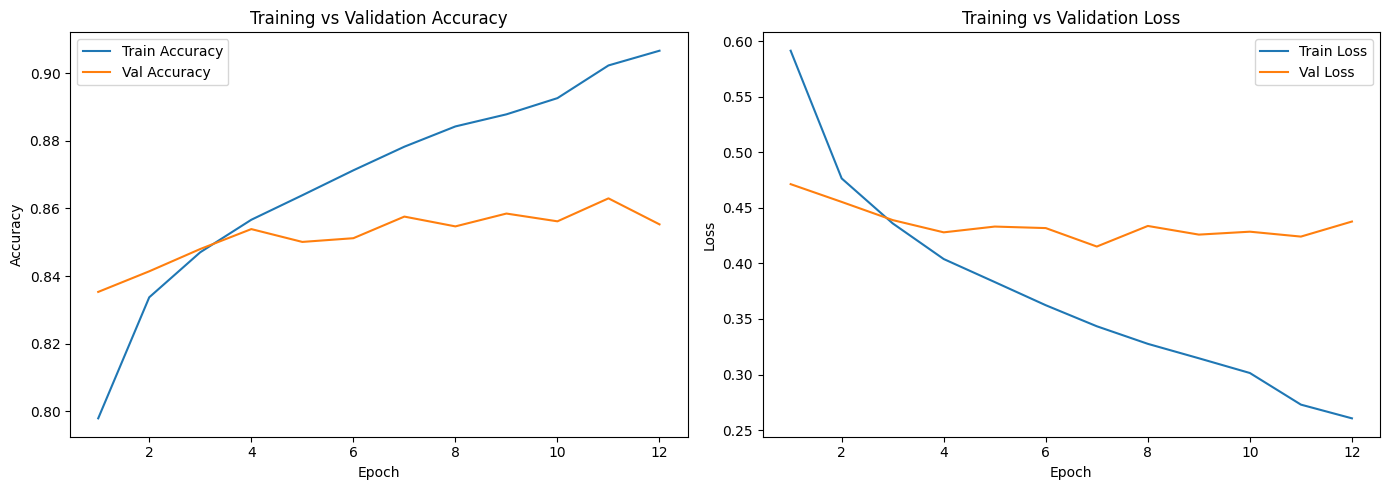

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Unfreeze top 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning phase
fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.7974 - loss: 0.6009 - val_accuracy: 0.8619 - val_loss: 0.4192 - learning_rate: 1.0000e-05
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.8654 - loss: 0.3810 - val_accuracy: 0.8702 - val_loss: 0.3900 - learning_rate: 1.0000e-05
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.8853 - loss: 0.3223 - val_accuracy: 0.8800 - val_loss: 0.3620 - learning_rate: 1.0000e-05
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.9006 - loss: 0.2853 - val_accuracy: 0.8825 - val_loss: 0.3501 - learning_rate: 1.0000e-05
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.9092 - loss: 0.2556 - val_accuracy: 0.8878 - val_loss: 0.3384 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


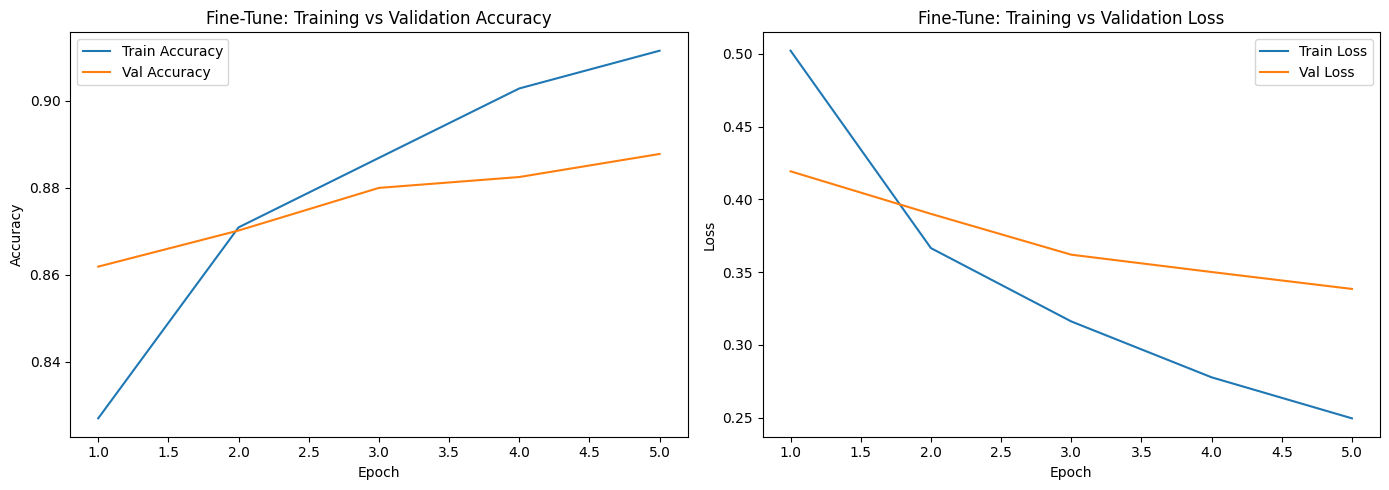

In [22]:
# Extract fine-tune training logs
ft_acc = fine_tune_history.history['accuracy']
ft_val_acc = fine_tune_history.history['val_accuracy']
ft_loss = fine_tune_history.history['loss']
ft_val_loss = fine_tune_history.history['val_loss']
ft_epochs = range(1, len(ft_acc) + 1)

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(ft_epochs, ft_acc, label='Train Accuracy')
plt.plot(ft_epochs, ft_val_acc, label='Val Accuracy')
plt.title('Fine-Tune: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ft_epochs, ft_loss, label='Train Loss')
plt.plot(ft_epochs, ft_val_loss, label='Val Loss')
plt.title('Fine-Tune: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##  Model Performance Evolution Report

###  Model 1: Baseline with Frozen MobileNetV2

- **Setup**: MobileNetV2 base (fully frozen), custom classifier head.
- **Training Epochs**: 12 (early stopped)
- **Accuracy**:
  - Training: ~90.6%
  - Validation: ~85.8%
- **Observation**:
  - Validation accuracy plateaued after Epoch 7.
  - Validation loss began increasing while training loss decreased.
- **Conclusion**: Model showed **early signs of overfitting**; generalization limited.

---

###  Model 2: Tuned Callbacks and Optimized Training

- **Improvements**:
  - Increased `EarlyStopping` patience to 5.
  - Adjusted `ReduceLROnPlateau` to `factor=0.7` with a `min_lr`.
  - Cleaned data pipeline for consistent input handling.
- **Training Epochs**: 12 (again early stopped)
- **Accuracy**:
  - Training: ~90.7%
  - Validation: ~86.3%
- **Observation**:
  - Validation metrics were more stable.
  - Slight improvements, but overfitting trend persisted.
- **Conclusion**: Better stability, but still room to improve generalization.

---

###  Model 3: Fine-Tuned Top Layers (Final Model)

- **Improvement**:
  - Unfroze top 20 layers of MobileNetV2.
  - Reduced learning rate to `1e-5` for safer weight updates.
- **Training Epochs**: 5 (no early stopping triggered)
- **Accuracy**:
  - Training: ~90.9%
  - Validation: **~88.8%**  _Best yet!_
- **Loss Trend**:
  - Validation loss decreased consistently throughout.
- **Conclusion**:
  - Model **no longer overfit**.
  - Validation performance improved steadily—showing true adaptation.
  - This version strikes the best balance between accuracy and generalization.

---

###  Final Verdict

Through thoughtful tuning and layer-wise fine-tuning, the final model overcame overfitting and achieved high validation accuracy. Visualizations confirmed stable, healthy convergence—making this version the best candidate for deployment or submission.